In [1]:
from math import ceil

import torch

from botorch.test_functions.multi_objective import GMM
from botorch.acquisition.risk_measures import VaR

from scalarize.utils.scalarization_functions import LinearScalarization

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
problem = GMM(negate=True, num_objectives=2)
n = 1001
t = torch.linspace(0, 1, n)
X, Y = torch.meshgrid(t, t, indexing="xy")

In [3]:
def get_objective_values(weight):
    sfn = LinearScalarization(weights=weight)
    Z = torch.zeros(X.shape, **tkwargs)
    for j in range(n):
        x_j = torch.column_stack([X[:, j], Y[:, j]])
        y_j = problem(x_j)
        Z[:, j] = sfn(y_j).squeeze(-1)

    # Expectation objective
    S = Z.mean(dim=-1)

    # VaR objective
    alpha = 0.1
    q = 1 - (ceil(n * alpha) - 1) / n
    R = torch.quantile(Z, q=q, dim=-1, keepdim=False, interpolation="lower")

    # Max-min objective
    # Take the minimum over the interval [0.2, 0.8].
    W = Z[..., n // 5 : 4 * n // 5].min(dim=-1).values

    # TV Objective
    epsilon = 0.5
    D = S - epsilon * (Z.max(dim=-1).values - Z.min(dim=-1).values)

    return Z, R, S, W, D

In [4]:
def plot_line(ax, A, color, title):

    ax.plot(t, A, color=color, linewidth=2)
    ax.set_title(title, fontsize=20)
    ax.axvline(t[A.argmax(dim=-1)], color=color, linewidth=2, linestyle="--")
    ax.scatter(
        t[A.argmax(dim=-1)],
        max(A),
        marker="*",
        edgecolor="k",
        color=color,
        linewidth=1,
        zorder=5,
        s=200,
    )
    r = max(A) - min(A)
    ax.set_ylim(min(A) - 0.2 * r, max(A) + 0.2 * r)
    ax.set_yticks([])
    ax.set_xlim(0, 1)

    return None


def plot_objectives(Z, R, S, W, D):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.remove()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=1)

    gs = fig.add_gridspec(6, 14)

    ##############################################################################
    ax = fig.add_subplot(gs[0:4, 0:4])
    ax.contour(X, Y, Z, colors="black", alpha=0.2)
    img = ax.imshow(Z, extent=[0, 1, 0, 1], origin="lower", cmap="jet", alpha=0.75)

    cbar = plt.colorbar(img)
    cbar.set_ticks([])
    ax.set_title("Scalarized objective", fontsize=20)
    ax.set_xlabel(r"$\mathbf{x}$", fontsize=20)
    ax.set_ylabel(r"$\boldsymbol{\xi}$", fontsize=20)
    ##############################################################################
    ax = fig.add_subplot(gs[0:2, 4:9])
    plot_line(ax, S, color="dodgerblue", title="Stochastic objective")
    ax.set_xticks([])
    ##############################################################################
    ax = fig.add_subplot(gs[0:2, 9:14])
    plot_line(ax, R, color="crimson", title="Risk-averse objective")
    ax.set_xticks([])
    ##############################################################################
    ax = fig.add_subplot(gs[2:4, 4:9])
    plot_line(ax, W, color="orange", title="Worst-case objective")
    ax.set_xlabel(r"$\mathbf{x}$", fontsize=20)
    ##############################################################################
    ax = fig.add_subplot(gs[2:4, 9:14])
    plot_line(ax, D, color="mediumseagreen", title="Distributionally robust objective")
    ax.set_xlabel(r"$\mathbf{x}$", fontsize=20)

    plt.show()
    return fig

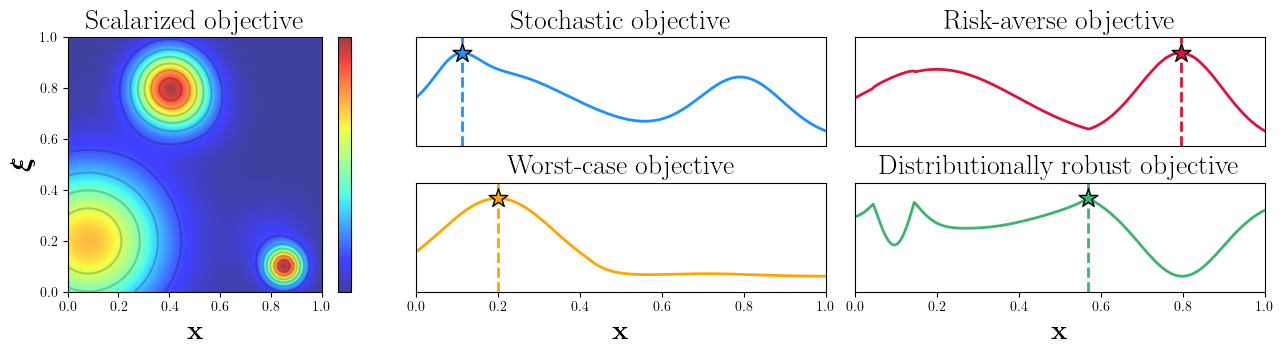

In [5]:
weight = torch.tensor([[0.1, 0.9]], **tkwargs)
fig = plot_objectives(*get_objective_values(weight))